In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

n_samples = 1000
df = pd.DataFrame({
    "pH": np.random.uniform(4.5, 8.0, n_samples),
    "Nitrogen": np.random.uniform(10, 80, n_samples),
    "Phosphorus": np.random.uniform(5, 60, n_samples),
    "Potassium": np.random.uniform(10, 100, n_samples),
    "Rainfall": np.random.uniform(200, 1000, n_samples),
    "Temperature": np.random.uniform(15, 40, n_samples),
    "Humidity": np.random.uniform(40, 90, n_samples),
    "Soil_Type": np.random.choice(["Loamy", "Sandy", "Clay"], n_samples),
    "Crop_Type": np.random.choice(["Wheat", "Rice", "Maize", "Cotton"], n_samples),
    "Season": np.random.choice(["Kharif", "Rabi", "Zaid"], n_samples),
    "Irrigation_Type": np.random.choice(["Drip", "Flood", "Sprinkler"], n_samples)
})

In [4]:
df["Crop_Yield"] = (
    0.5 * df["Nitrogen"] +
    0.35 * df["Rainfall"]/100 +
    0.25 * df["Temperature"] -
    0.15 * df["pH"] +
    # np.random.normal(0, 1.2, n_samples)
    np.random.normal(0, 1.0, n_samples)

)

print("✅ Dataset ready:", df.shape)
print(df.head())


✅ Dataset ready: (1000, 12)
         pH   Nitrogen  Phosphorus  Potassium    Rainfall  Temperature  \
0  5.810890  22.959305   19.393813  70.543269  657.596703    24.840888   
1  7.827500  47.933066   18.583834  81.701326  844.345863    26.835891   
2  7.061979  71.106209   54.844002  32.542111  808.128744    36.363685   
3  6.595305  61.255742   18.725041  66.238669  323.119924    23.500110   
4  5.046065  66.459280   19.957235  61.457138  319.399576    36.741242   

    Humidity Soil_Type Crop_Type  Season Irrigation_Type  Crop_Yield  
0  72.412848      Clay     Wheat    Zaid            Drip   18.624865  
1  48.619318     Loamy     Wheat    Rabi           Flood   31.440596  
2  83.619728      Clay     Maize    Zaid           Flood   44.668419  
3  70.655812      Clay      Rice  Kharif            Drip   35.589198  
4  47.860194     Loamy     Maize    Zaid       Sprinkler   42.452031  


In [5]:
from sklearn.model_selection import train_test_split


In [6]:
numeric_features = ["pH", "Nitrogen", "Phosphorus", "Potassium", "Rainfall", "Temperature", "Humidity"]
categorical_features = ["Soil_Type", "Crop_Type", "Season", "Irrigation_Type"]

X = df[numeric_features + categorical_features]
y = df["Crop_Yield"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [10]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])


In [11]:
from xgboost import XGBRegressor

In [12]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        # n_estimators=800,
        n_estimators = 1200,
        max_depth = 8,
        learning_rate = 0.02,
        # learning_rate=0.03,
        # max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1,
        reg_alpha=0.3,
        random_state=42
    ))
])


In [13]:
pipeline.fit(X_train, y_train)
print("✅ Model trained successfully!")

✅ Model trained successfully!


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")     ####MAE: 1.239 OLD
print(f"RMSE: {rmse:.3f}")   ###RMSE: 1.530 OLD
print(f"R²: {r2:.3f}")       ####R²: 0.980 OLD

MAE: 0.983
RMSE: 1.223
R²: 0.987


C:\Users\turni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


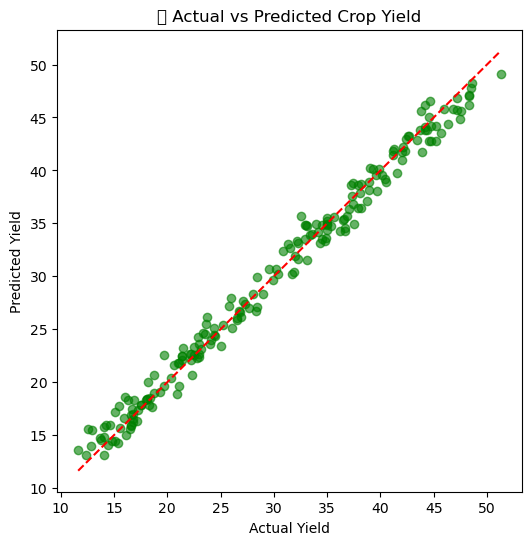

C:\Users\turni\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


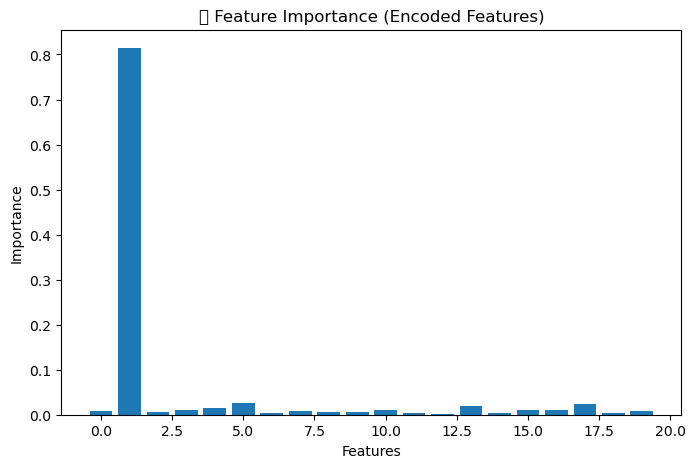

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="green")
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("🌾 Actual vs Predicted Crop Yield")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()

model = pipeline.named_steps["model"]
plt.figure(figsize=(8,5))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("🌱 Feature Importance (Encoded Features)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [17]:
import pickle
pickle.dump(pipeline, open('crop_yield_model(improved).pkl', 'wb'))
print('Saved to crop_yield_model(improved).pkl')

Saved to crop_yield_model(improved).pkl
